# STPSF Tutorial

***

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Introduction

STPSF is a realistic point spread function (PSF) simulator developed by STScI that supports both Roman and the James Webb Space Telescope. For Roman's Wide Field Imager (WFI), it uses the NASA Goddard Space Flight Center's latest optical models, including field-dependent aberrations across the WFI focal plane. There is also an experimental module for Roman's Coronagraph Instrument. For more information on the tool, please visit the [RDox pages on STPSF for Roman](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stpsf-for-roman).

**Note:** STPSF was formerly called WebbPSF. For more information, see [Transitioning from WebbPSF to STPSF](https://stpsf.readthedocs.io/en/latest/webbpsf_to_stpsf.html).

This tutorial provides an introduction to simulating Roman WFI PSFs and computing standard PSF properties like full width at half maximum (FWHM) and encircled energy (EE).

## Imports

- *matplotlib* for plotting data
- *astropy.units* for unit manipulation
- *stpsf* for simulating Roman WFI PSFs
- *numpy* for array calculations

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from astropy import units as u
import numpy as np
import stpsf

We also edit `matplotlib`'s interpolation setting to prevent any smoothing of pixel edges.

In [2]:
rcParams['image.interpolation'] = 'nearest'

***

## Examples

### Quick PSF generation

#### Default parameters

After selecting the proper instrument (Roman WFI), generating a PSF can be as short as a single line. In the cell below, we will use the `.calc_psf()` method to compute a WFI PSF using mostly default settings. The one argument we will change is to specify `nlambda=1`, which will create a monochromatic PSF evaluated at the average wavelength of the minimum and maximum of the bandpass (in this case, the default bandpass is F062). The minimum and maximum wavelengths of the bandpass are defined as 10% of the throughput. A polychromatic PSF may be simulated by setting `nlambda` > 1, which will sample that number of wavelengths evenly spaced throughout the bandpass.

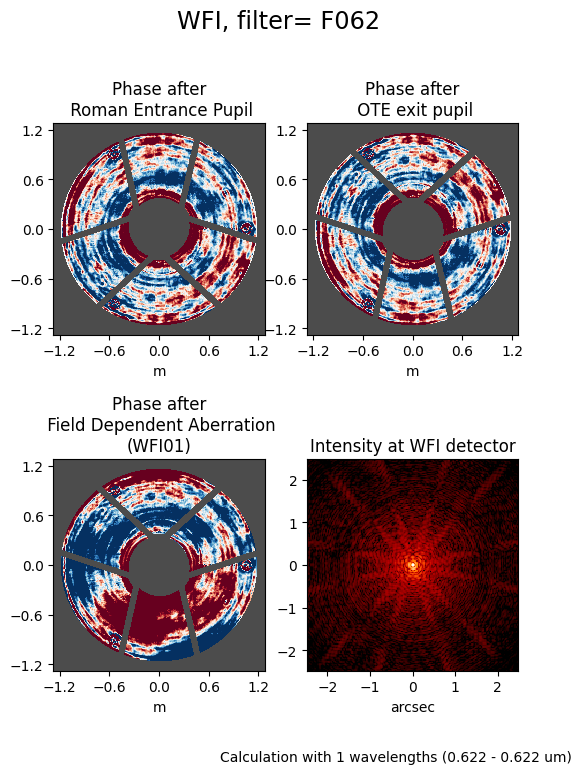

In [3]:
wfi = stpsf.roman.WFI()
plt.figure(figsize=(6, 8))
default_psf = wfi.calc_psf(display=True, nlambda=1)

As you can see above, the calculation was performed at one wavelength (0.6225 microns). Suppose we want to make a monochromatic PSF at some other wavelength, we can do that using the `monochromatic` argument, which should be set to the desired wavelength in units of meters. For example, we can use the pivot wavelength of the bandpass:

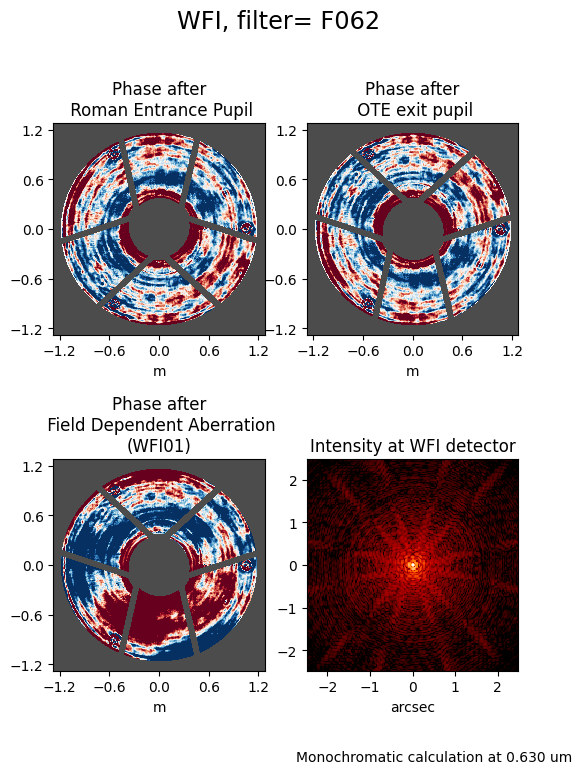

In [4]:
plt.figure(figsize=(6, 8))
wfi_f062 = stpsf.roman.WFI()._get_synphot_bandpass('F062')
pivot_f062 = wfi_f062.pivot().to(u.meter).value
default_psf = wfi.calc_psf(display=True, monochromatic=pivot_f062)

The resulting object (in this case, the variable `default_psf`) contains a list of four FITS extensions containing idealized PSF images. `OVERSAMP` splits the detector's original number of pixels by the oversampling factor specified upon creation of the PSFs (by default, 4) while `DET_SAMP` retains the native pixel sampling. Similarly, the `OVERDIST` and `DET_DIST` extensions represent the oversampled and native pixel sampling with distortion applied. 

In [5]:
default_psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      53   (184, 184)   float64   
  1  DET_SAMP      1 ImageHDU        55   (46, 46)   float64   
  2  OVERDIST      1 ImageHDU        54   (184, 184)   float64   
  3  DET_DIST      1 ImageHDU        55   (46, 46)   float64   


The package includes a helper function for visualizing each extension of an existing PSF. For example, if we want to examine the oversampled PSF from the simulation we generated above:

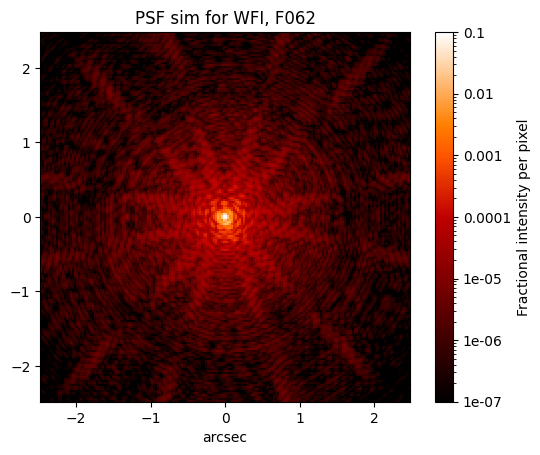

In [6]:
stpsf.display_psf(default_psf, ext='OVERSAMP')

We can use any of the extensions in the `default_psf` variable that we created in the plotting routine demonstrated above. The PSF object also contains a method (`.writeto()`) for saving the PSF model to disk:

In [7]:
default_psf.writeto('default_PSF.fits', overwrite=True)

#### Custom parameters

You can simulate custom PSFs by modifying instrument class attributes like the detector, filter, and others. All available attributes are described in the STPSF API documentation for the [Roman WFI class](https://stpsf.readthedocs.io/en/latest/api/stpsf.WFI.html#stpsf.WFI) and its parent [SpaceTelescopeInstrument class](https://stpsf.readthedocs.io/en/latest/api/stpsf.SpaceTelescopeInstrument.html#stpsf.SpaceTelescopeInstrument).) Let's first get a list of the available optical elements:

In [8]:
wfi.filter_list

[np.str_('F062'),
 np.str_('F087'),
 np.str_('F106'),
 np.str_('F129'),
 np.str_('F146'),
 np.str_('F158'),
 np.str_('F184'),
 np.str_('PRISM'),
 np.str_('F213'),
 np.str_('GRISM0'),
 np.str_('GRISM1')]

While the imaging filters have names that start with "F" (e.g., F158), the prism has the allcaps name "PRISM" and the grism has two options: "GRISM0" and "GRISM1", which correspond to the zeroth and first orders, respectively. For more information on the WFI optical elements, see the [WFI Optical Elements](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/wfi-design/wfi-optical-elements) article on RDox.

Next, let's simulate the PSF of the first-order grism spectrum. For this simulation, we will select the detector WFI14 and a position on the detector of (x, y) = (1024, 1024) in science coordinates. The detector names in STPSF are in the format SCAXX rather than WFIXX, so we will specify this as SCA14.

**Note:** The following cell is commented out as it takes a very long time to run. To run it, simply uncomment the lines and run the cell, and you may want to find something else to do while it runs.

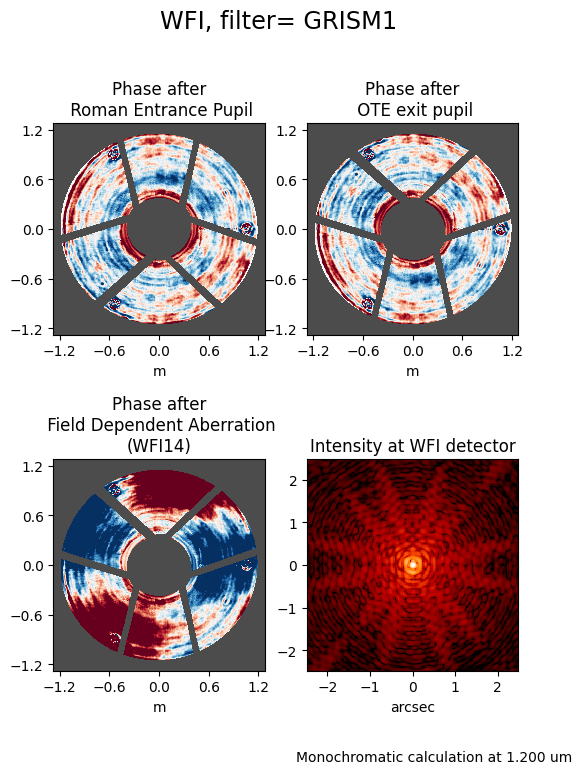

In [9]:
wfi.filter = 'GRISM1'
wfi.detector = 'SCA14'
wfi.detector_position = (1024, 1024)

plt.figure(figsize=(6, 8)) 
custom_psf = wfi.calc_psf(display=True, monochromatic=1.2e-6)

### PSF profile and encircled energy

Once you've simulated a PSF, STPSF offers a method that measures its profile, FWHM, and encircled energy. Let's create a source spectrum of a star with spectral type G0V using the PHOENIX model library. Then, we will compute a polychromatic PSF in ten wavelength bins (given by the optional argument `nlambda`).

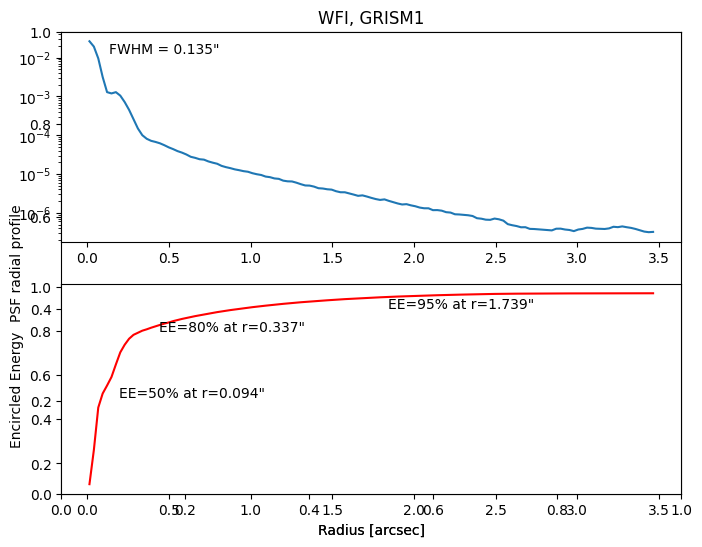

In [10]:
src = stpsf.specFromSpectralType('G0V', catalog='phoenix')
poly_psf = wfi.calc_psf(source=src, nlambda=10, display=False)

plt.figure(figsize=(8, 6))
stpsf.display_profiles(poly_psf)

### Bulk PSF generation

To generate several individual PSFs in a grid, STPSF implements the `GriddedPSFModel` class from `photutils`. (Learn more about this use case in the [STPSF documentation](https://stpsf.readthedocs.io/en/latest/psf_grids.html).)

As a toy example, below we generate a 3x3 grid of PSFs for a single WFI detector.

In [11]:
wfi.detector = "SCA07"
wfi.filter = "F158"
wfi_grid = wfi.psf_grid(num_psfs=9, all_detectors=False)


Running instrument: WFI, filter: F158
  Running detector: WFI07
    Position 1/9: (0, 0) pixels


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (28.9941222186931, 0.014184991300730587)


    Position 1/9 centroid: (np.float64(201.09217677683284), np.float64(201.99659785742992))
    Position 2/9: (0, 2048) pixels


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


Attempted to get aberrations at field point (0, 2048) which is outside the range of the reference data; approximating to nearest interpolated point (27.992165511351654, 2048.013694797217)


    Position 2/9 centroid: (np.float64(201.1156920991988), np.float64(202.05371442872885))
    Position 3/9: (0, 4095) pixels


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


    Position 3/9 centroid: (np.float64(201.13927911215228), np.float64(202.10946192564887))
    Position 4/9: (2048, 0) pixels


    Position 4/9 centroid: (np.float64(201.19176062580496), np.float64(202.0069346894154))
    Position 5/9: (2048, 2048) pixels


    Position 5/9 centroid: (np.float64(201.19077998247153), np.float64(202.1182246373882))
    Position 6/9: (2048, 4095) pixels


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


Attempted to get aberrations at field point (2048, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2048.004527894336, 4076.4944958472947)


    Position 6/9 centroid: (np.float64(201.2469947193439), np.float64(202.17667513400622))
    Position 7/9: (4095, 0) pixels


    Position 7/9 centroid: (np.float64(201.29308955252677), np.float64(202.01678300638105))
    Position 8/9: (4095, 2048) pixels


    Position 8/9 centroid: (np.float64(201.32443223542134), np.float64(202.13170742478255))
    Position 9/9: (4095, 4095) pixels


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (4095.0044053456836, 4076.9953521911784)


    Position 9/9 centroid: (np.float64(201.35583935199062), np.float64(202.24405439713556))


First, let's use the `plot_grid()` method to display the PSF grid:

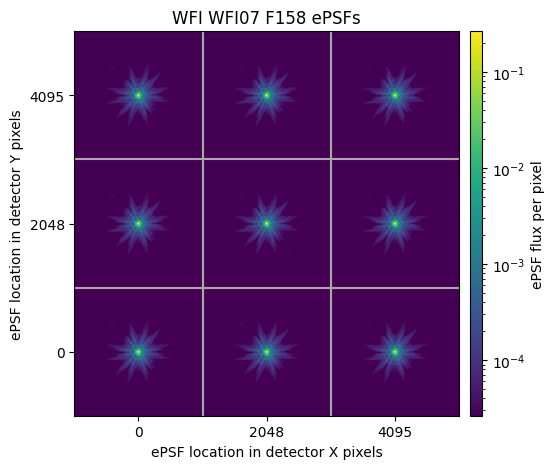

In [12]:
plot = wfi_grid.plot_grid()

Next let's look at the delta plot, which subtracts the mean from each PSF to show the variation across the detector:

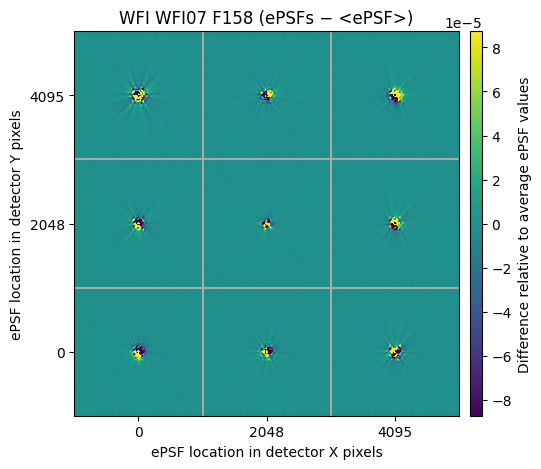

In [13]:
diffs = wfi_grid.plot_grid(deltas=True)

With a PSF grid in hand, you can use a package like `photutils` to estimate PSFs at any given detector position by interpolation without the need to calculate each PSF individually. This is a major time-saver in source-heavy scientific use cases. We do this by using the `evaluate()` method to determine the flux of any pixel relative to a PSF at any location. In the cell below, we will evaluate the flux per pixel around a PSF at position (X, Y) = (1000, 2000). We make a pixel grid around that position with 50 pixels on a side. We then pass each pixel position into the evaluate function and display the values that are returned for each pixel position. We have chosen to set the integrated flux of the PSF to a value of 1 in arbitrary units, which can then be conveniently scaled to the desired flux in other applications.

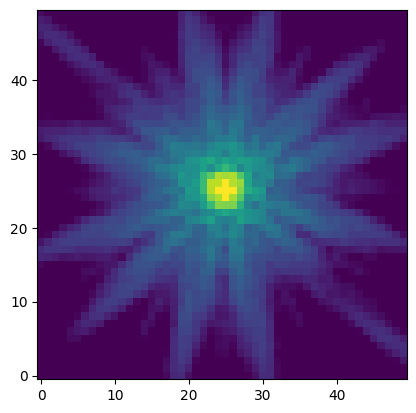

In [14]:
size = 50  # pixels on a side
x0 = 1000
y0 = 2000
x, y = np.mgrid[x0-size//2:x0+size//2, y0-size//2:y0+size//2]  # grid of pixel positions around PSF center

# Evaluate the PSF
psf = wfi_grid.evaluate(x=x, y=y, flux=1, x_0=x0, y_0=y0)

# Display the PSF
plt.imshow(psf, norm=LogNorm(vmax=0.05, vmin=1e-5), origin='lower')

## Additional Resources

- The Roman User Documentation's ["STPSF Overview"](https://roman-docs.stsci.edu/simulation-tools-handbook-home/stpsf-for-roman/overview-of-stpsf) page.
- The latest version of the [STPSF documentation](https://stpsf.readthedocs.io/en/stable/index.html) on ReadTheDocs, which includes a specific page on the package's [Roman instrument model](https://stpsf.readthedocs.io/en/stable/roman.html).
- The [Roman Help Desk](https://romanhelp.stsci.edu), an official outlet for user questions about STPSF.

***

## About this Notebook

**Authors:** Justin Otor, Eunkyu Han, Tyler Desjardins, Charles-Philippe Lajoie\
**Updated On:** 2025-05-26

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>